In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Tikhonov regularization

In this Notebook, we compute regression polynomials with and without Tikhonov regularization.
See `Tikhonov.pdf` for more background information and analysis.
First, we define the data:

In [2]:
x = np.array([-0.5,0.0,0.001,0.5])
y = np.array([-1, 0, 0.001, 1.5])

and the perturbed data: 

In [3]:
yhat=y.copy()
yhat[1]=0.01

### Plot the data

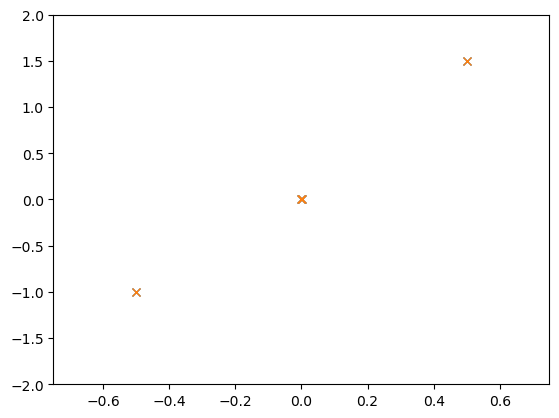

In [4]:
plt.plot(x,y, 'x', x,yhat, 'x')
plt.xlim(-.75,.75);
plt.ylim(-2,2);

Now, we compute the "least squares" regression 
$$ f(x)=\beta_0 x^3 +\beta_1 x^2 + \beta_2 x + \beta_3 $$
Notice that the coefficients are in the reverse order compared with the pdf. This is to take advantage of the numpy functions `np.vander` and `np.polyval`.

The design matrix for a basis of functions $1, x, x^2, \dotsc, x^k$ is so commonly used that it has its own name: The Vandermonde matrix. In numpy, we can compute the Vandermonde matrix for a vector of $x-$coordinates with `np.vander`. 
The columns are in the opposite order of what is used in Lay.

One property of the Vandermonde matrix is that it can be badly conditioned, especially when some of the $x$-values are close.

In [5]:
deg=3
X=np.vander(x,deg+1)
print(X)
print(np.linalg.cond(X))

[[-1.25e-01  2.50e-01 -5.00e-01  1.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]
 [ 1.00e-09  1.00e-06  1.00e-03  1.00e+00]
 [ 1.25e-01  2.50e-01  5.00e-01  1.00e+00]]
11754.10236802956


We solve the least squares problem using `np.linalg.lstsq`. This function returns a tuple consisting of
 * the least-squares solution $\mathbf{\beta}$
 * the residual $\|\mathbf{y}-X\mathbf{\beta}\|^2$
 * the rank of $X$
 * the singular values of $X$.
 
We only use the solution, which we can pick out with `[0]`.
 
We solve the least-squares problem for both the initial data `y` and the perturbed data `yhat`. and plot the two resulting functions. 

In [6]:

beta=np.linalg.lstsq(X,y, rcond=None)[0]
betahat=np.linalg.lstsq(X,yhat,rcond=None)[0]

print(str(beta))
print(str(betahat))

[ 6.00402402e+00  1.00000000e+00  9.98993996e-01 -1.81523162e-16]
[ 4.6004024e+01  9.6000000e-01 -9.0010060e+00  1.0000000e-02]


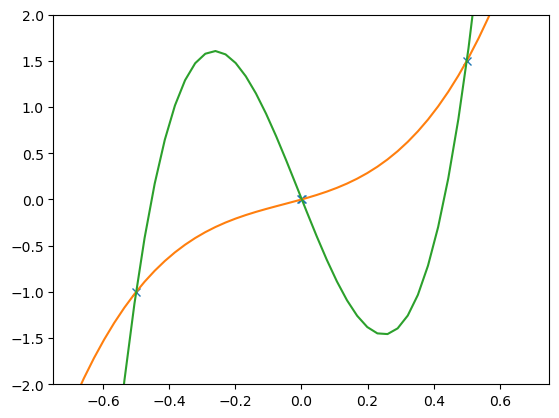

In [7]:
xrange=np.linspace(-.75,.75)
plt.plot(x,y,'x',xrange, np.polyval(beta, xrange), xrange, np.polyval(betahat, xrange))
plt.xlim(-.75,.75);
plt.ylim(-2,2);

As we can see, the two datasets produce vastly different results.

## Regularization 

For the Tikhonov regularized regression, we need to expand the least squares problem to 

$$\begin{bmatrix}
    X \\ \alpha I
    \end{bmatrix}\boldsymbol{\beta} - 
    \begin{bmatrix} 
    \mathbf{y}\\ \mathbf{0}
    \end{bmatrix}
$$
(See the pdf.)

We can do this using `np.vstack` and `np.concatenate`.
We choose $\alpha=0.01$.

In [8]:
alpha=0.01
X_tikh=np.vstack((X, alpha*np.eye(deg+1)))
y_tikh= np.concatenate((y, np.zeros(deg+1)))
y_tikh_hat= np.concatenate((yhat, np.zeros(deg+1)))
print('X_{tikh}=\n'+str(X_tikh))
print('y_{tikh}=\n'+str(y_tikh))

X_{tikh}=
[[-1.25e-01  2.50e-01 -5.00e-01  1.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e+00]
 [ 1.00e-09  1.00e-06  1.00e-03  1.00e+00]
 [ 1.25e-01  2.50e-01  5.00e-01  1.00e+00]
 [ 1.00e-02  0.00e+00  0.00e+00  0.00e+00]
 [ 0.00e+00  1.00e-02  0.00e+00  0.00e+00]
 [ 0.00e+00  0.00e+00  1.00e-02  0.00e+00]
 [ 0.00e+00  0.00e+00  0.00e+00  1.00e-02]]
y_{tikh}=
[-1.0e+00  0.0e+00  1.0e-03  1.5e+00  0.0e+00  0.0e+00  0.0e+00  0.0e+00]


In [9]:
beta_tikh=np.linalg.lstsq(X_tikh, y_tikh, rcond=None)[0]
beta_tikh_hat=np.linalg.lstsq(X_tikh, y_tikh_hat, rcond=None)[0]
print('beta=\n'+str(beta_tikh))
print('betahat=\n'+str(beta_tikh_hat))

beta=
[ 5.90187104e-01  1.00110409e+00  2.35198107e+00 -4.76245001e-04]
betahat=
[0.6019361  0.98113103 2.34903443 0.004521  ]


And we plot the regression functions

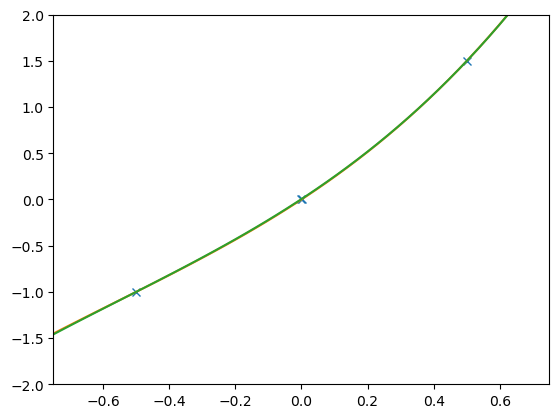

In [10]:
plt.plot(x,y, 'x', xrange,np.polyval(beta_tikh, xrange), xrange,np.polyval(beta_tikh_hat, xrange))
plt.xlim(-.75,.75);
plt.ylim(-2,2);

We measure the interpolation errors:

In [11]:
print(np.polyval(beta_tikh, x))
print(y-np.polyval(beta_tikh, x))

[-9.99964148e-01 -4.76245001e-04  1.87673777e-03  1.49956370e+00]
[-3.58522738e-05  4.76245001e-04 -8.76737768e-04  4.36297417e-04]


### Choosing the parameter $\alpha$

$\alpha$ controls the weight given to the two competing objectives of interpolating the data and making the norm of the parameters as small as possible. 
If $\alpha$ is large, the Tikhonov regularized solution will have small $\|\boldsymbol {\beta}\|$, but large residual $\|X\boldsymbol{\beta}-\mathbf{y}\|$.
When $\alpha$ becomes smaller, more weight is put on interpolating the data, so $\|\boldsymbol{\beta}\|$ grows larger, while $\|X\boldsymbol{\beta}-\mathbf{y}\|$ shrinks towards zero.

We make a function that solves the Tikhonov regularized problem

$$\min_\textbf{x} \|A\textbf{x}-\textbf{b}\|^2+\alpha^2 \|\textbf{x}\|^2$$
for arbitrary $A, \textbf{b}, \alpha$.

In [12]:
def tikhonov(A, b, alpha):
    (m,n)=np.shape(A)
    A_tikh=np.vstack((A, alpha*np.eye(n)))
    b_tikh= np.concatenate((y, np.zeros(n)))
    return np.linalg.lstsq(A_tikh, b_tikh, rcond=None) 

Now, we compute the Tikhonov regularized solution for our test problem with $\alpha$ in the range $[10^{-5}, 1]$, and compute the norm of the computed parameters $\boldsymbol{\beta}$, and the residual $X\boldsymbol{\beta}-\mathbf{y}$. `np.lstsq` returns the square of the norm of the residual, so we utilize that.

In [13]:
alphas=10.**np.arange(0,-5,-.05)
Betanorm=[]
Resnorm=[]
for a in alphas:
    beta,residues,_,_=tikhonov(X,y,a)
    Betanorm.append(np.linalg.norm(beta))
    Resnorm.append(residues[0]**0.5)
Betanorm=np.array(Betanorm)
Resnorm=np.array(Resnorm)

Now, we plot the norms as functions of $\alpha$. We use logarithmic scales.

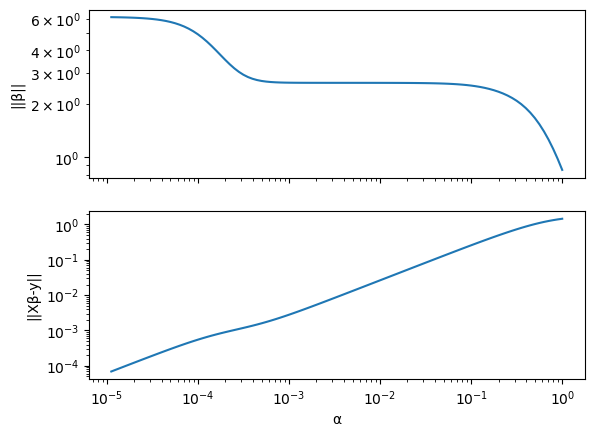

In [14]:
fig, axs= plt.subplots(2,1, sharex=True)

axs[0].loglog(alphas, Betanorm)
axs[0].set_ylabel('||β||')
axs[1].loglog(alphas, Resnorm)
axs[1].set_ylabel('||Xβ-y||')
axs[1].set_xlabel('α');

The monotonicity of the curves are as expected: larger $\alpha$ means smaller $\|\boldsymbol{\beta}\|$ and larger $\|X\boldsymbol{\beta}-\mathbf{y}\|$. We notice there is a plateau where $\|\boldsymbol{\beta}\|$ is almost constant. 


Plotting $\|\boldsymbol{\beta}\|$ versus $\|X\boldsymbol{\beta}-\mathbf{y}\|$ in a loglog-plot creates the so-called L-curve plot. 

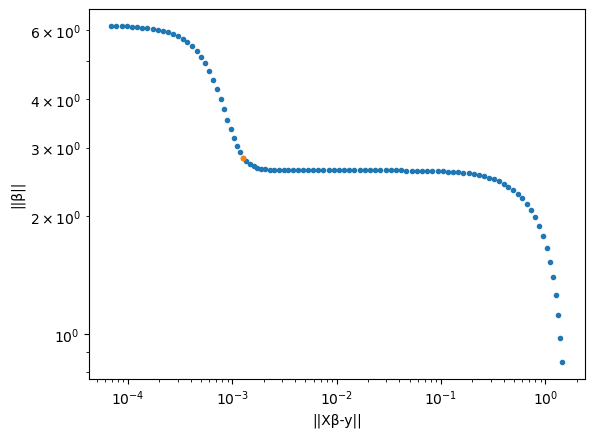

In [15]:
plt.loglog(Resnorm,Betanorm, '.')
plt.xlabel('||Xβ-y||')
plt.ylabel('||β||')
plt.loglog(Resnorm[69], Betanorm[69], '.')

One suggestion for choice of parameter $\alpha$ is to aim for the "corner" of the L-curve plot. 

(See https://www.sintef.no/globalassets/project/evitameeting/2005/lcurve.pdf/)

In our case, that would lead to choosing $\alpha\approx 0.00035$.

This is the point marked with an orange dot in the plot above.